# Daily Thermal and Inverter Loss Estimation


# Importing libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import pvlib
import pytz

# Importing weather data

In [2]:
Weather_data = pd.read_excel("Weather Station Parameter Irradiance.xlsx")

In [3]:
Weather_data["Tilted_Energy (Wh/m2)"]=(Weather_data['Tilted (W/m2)'])/12

In [4]:
Weather_data.head()

,DateTime,Tilted (W/m2),Temp (°C),WS (m/s),Tilted_Energy (Wh/m2)
0,2022-03-15 06:10:00,2,20.36,2.97,0.166667
1,2022-03-15 06:15:00,3,20.72,2.97,0.250000
2,2022-03-15 06:20:00,6,21.01,2.97,0.500000
3,2022-03-15 06:25:00,9,21.25,2.97,0.750000
4,2022-03-15 06:30:00,15,21.62,2.97,1.250000


In [5]:
Weather_data["DateTime"] = pd.to_datetime(Weather_data["DateTime"])

In [6]:
Weather_data= Weather_data.set_index("DateTime")

In [7]:
Weather_data.head()

,Tilted (W/m2),Temp (°C),WS (m/s),Tilted_Energy (Wh/m2)
DateTime,,,,
2022-03-15 06:10:00,2,20.36,2.97,0.166667
2022-03-15 06:15:00,3,20.72,2.97,0.250000
2022-03-15 06:20:00,6,21.01,2.97,0.500000
2022-03-15 06:25:00,9,21.25,2.97,0.750000
2022-03-15 06:30:00,15,21.62,2.97,1.250000


# Panel Temperature modeling

In [8]:
all_parameters = pvlib.temperature.TEMPERATURE_MODEL_PARAMETERS['sapm']
list(all_parameters.keys())

['open_rack_glass_glass',
 'close_mount_glass_glass',
 'open_rack_glass_polymer',
 'insulated_back_glass_polymer']

In [9]:
parameters = all_parameters['open_rack_glass_polymer']
# note the "splat" operator "**" which expands the dictionary "parameters"
# into a comma separated list of keyword arguments
cell_temperature = pvlib.temperature.sapm_cell(
    Weather_data["Tilted (W/m2)"], Weather_data['Temp (°C)'], Weather_data['WS (m/s)'], **parameters)

In [23]:
cell_temperature.head(74)

DateTime
2022-03-15 06:10:00    20.411520
2022-03-15 06:15:00    20.797280
2022-03-15 06:20:00    21.164560
2022-03-15 06:25:00    21.481840
2022-03-15 06:30:00    22.006400
                         ...    
2022-03-15 11:55:00    58.283070
2022-03-15 12:00:00    59.041403
2022-03-15 12:05:00    58.817959
2022-03-15 12:10:00    58.886648
2022-03-15 12:15:00    59.004026
Length: 74, dtype: float64

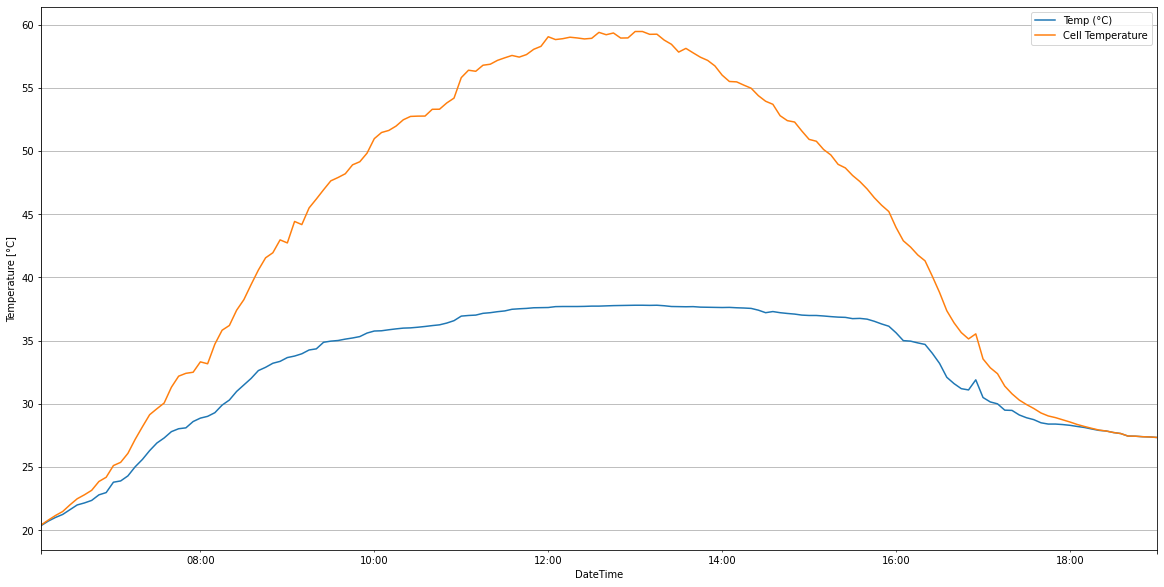

In [11]:
Weather_data['Temp (°C)'].plot(figsize=(20, 10))
cell_temperature.plot(figsize=(20, 10))
plt.grid()
plt.legend(['Temp (°C)', 'Cell Temperature'])
# note Python 3 can use unicode characters like the degrees symbol
plt.ylabel('Temperature [°C]');

In [11]:
nameplate = 351e3

In [12]:
dc_power=((Weather_data["Tilted (W/m2)"])/1000)*nameplate

In [13]:
dc_power.head()

DateTime
2022-03-15 06:10:00     702.0
2022-03-15 06:15:00    1053.0
2022-03-15 06:20:00    2106.0
2022-03-15 06:25:00    3159.0
2022-03-15 06:30:00    5265.0
Name: Tilted (W/m2), dtype: float64

# Temperature corrected power

In [14]:
gamma_pdc = -0.004  # divide by 100 to go from %/°C to 1/°C
nameplate = 351e3

Temp_Corrected_power = pvlib.pvsystem.pvwatts_dc(Weather_data["Tilted (W/m2)"], cell_temperature, nameplate, gamma_pdc)

In [15]:
Temp_Corrected_power.head()

DateTime
2022-03-15 06:10:00     714.884452
2022-03-15 06:15:00    1070.701856
2022-03-15 06:20:00    2138.309746
2022-03-15 06:25:00    3203.455468
2022-03-15 06:30:00    5328.045211
dtype: float64

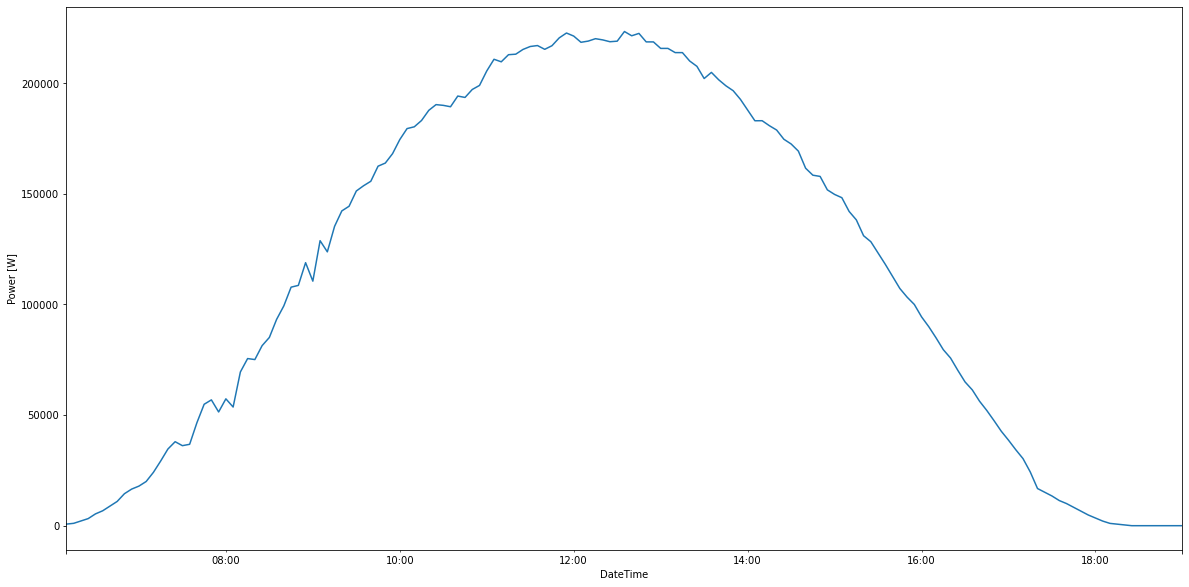

In [16]:
Temp_Corrected_power.plot(figsize=(20, 10))
plt.ylabel('Power [W]');

In [17]:
Thermal_Loss= dc_power-Temp_Corrected_power

In [19]:
Thermal_Loss.head(50)

DateTime
2022-03-15 06:10:00      -12.884452
2022-03-15 06:15:00      -17.701856
2022-03-15 06:20:00      -32.309746
2022-03-15 06:25:00      -44.455468
2022-03-15 06:30:00      -63.045211
2022-03-15 06:35:00      -66.971691
2022-03-15 06:40:00      -77.079587
2022-03-15 06:45:00      -80.146814
2022-03-15 06:50:00      -65.843970
2022-03-15 06:55:00      -53.402721
2022-03-15 07:00:00        8.395446
2022-03-15 07:05:00       29.787916
2022-03-15 07:10:00      104.835279
2022-03-15 07:15:00      258.230946
2022-03-15 07:20:00      446.870705
2022-03-15 07:25:00      639.555153
2022-03-15 07:30:00      679.898353
2022-03-15 07:35:00      760.700294
2022-03-15 07:40:00     1205.364952
2022-03-15 07:45:00     1624.888371
2022-03-15 07:50:00     1738.191574
2022-03-15 07:55:00     1590.048671
2022-03-15 08:00:00     1974.095960
2022-03-15 08:05:00     1812.410920
2022-03-15 08:10:00     2812.429510
2022-03-15 08:15:00     3419.405769
2022-03-15 08:20:00     3521.726019
2022-03-15 08:25:00

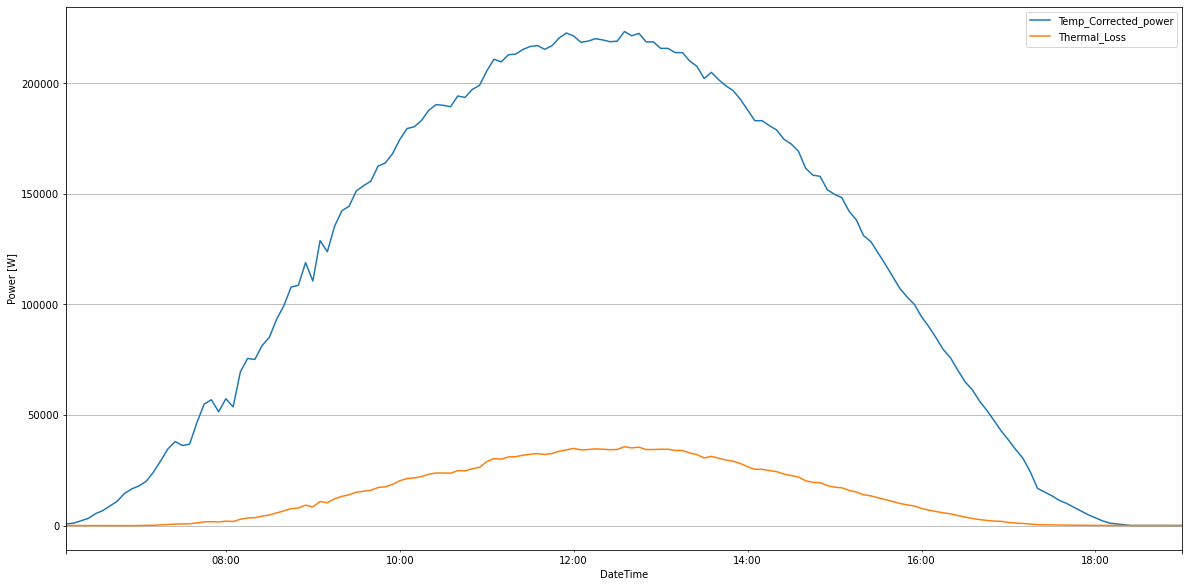

In [21]:
Temp_Corrected_power.plot(figsize=(20, 10),label="Temp_Corrected_power")
Thermal_Loss.plot(figsize=(20, 10),label="Thermal_Loss")
plt.ylabel('Power [W]');
plt.grid()
plt.legend()

# AC/DC

In [23]:
pdc0 = 300000/0.96  # W
ac = pvlib.inverter.pvwatts(Temp_Corrected_power, pdc0)

In [25]:
ac.head()

DateTime
2022-03-15 06:10:00       0.000000
2022-03-15 06:15:00       0.000000
2022-03-15 06:20:00     262.945281
2022-03-15 06:25:00    1308.640692
2022-03-15 06:30:00    3394.083967
dtype: float64

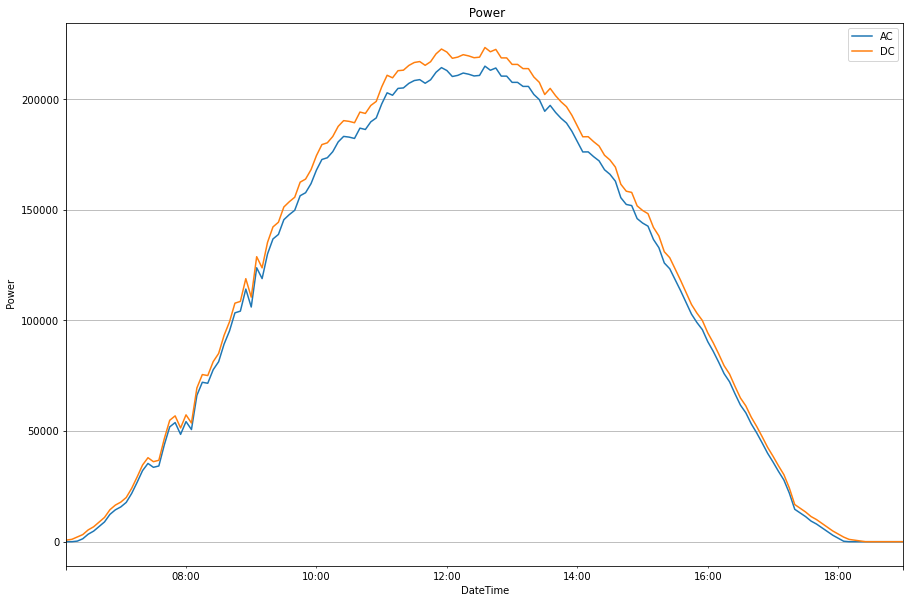

In [26]:
ac.plot(figsize=(15, 10), label='AC')
Temp_Corrected_power.plot(figsize=(15, 10), label='DC')
plt.title(' Power')
plt.ylabel(' Power')
plt.grid()
plt.legend()

In [27]:
Inverter_Loss=Temp_Corrected_power-ac

In [28]:
Inverter_Loss.head()

DateTime
2022-03-15 06:10:00     714.884452
2022-03-15 06:15:00    1070.701856
2022-03-15 06:20:00    1875.364465
2022-03-15 06:25:00    1894.814776
2022-03-15 06:30:00    1933.961245
dtype: float64

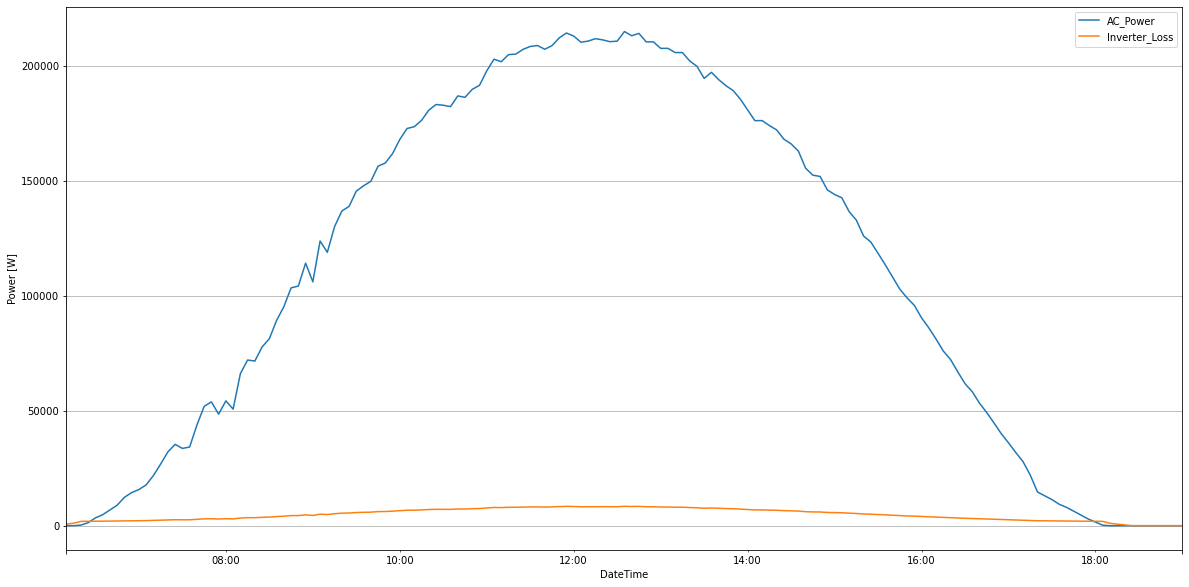

In [29]:
ac.plot(figsize=(20, 10),label='AC_Power')
Inverter_Loss.plot(figsize=(20, 10),label='Inverter_Loss')
plt.grid()
plt.legend()
plt.ylabel('Power [W]');

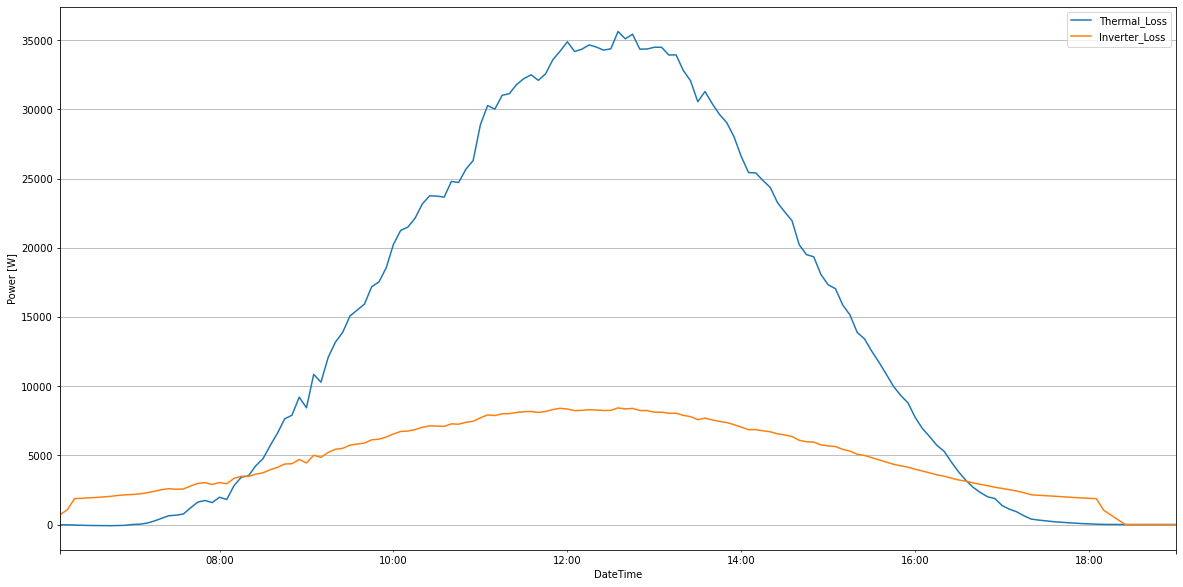

In [47]:
Thermal_Loss.plot(figsize=(20, 10),label='Thermal_Loss')
Inverter_Loss.plot(figsize=(20, 10),label='Inverter_Loss')
plt.grid()
plt.legend()
plt.ylabel('Power [W]');

In [30]:
#Thermal_loss_day=Thermal_Loss.sum()
#Inverter_Loss_day=Inverter_Loss.sum()
#Thermal_loss_day.plot(figsize=(20, 10),label='Thermal_Loss')
#Inverter_Loss_day=Inverter_Loss.resample('D').sum()
#Inverter_Loss_day.plot(figsize=(20, 10),label='Inverter_Loss')
#plt.grid()
#plt.legend()
#plt.ylabel('Power [W]');

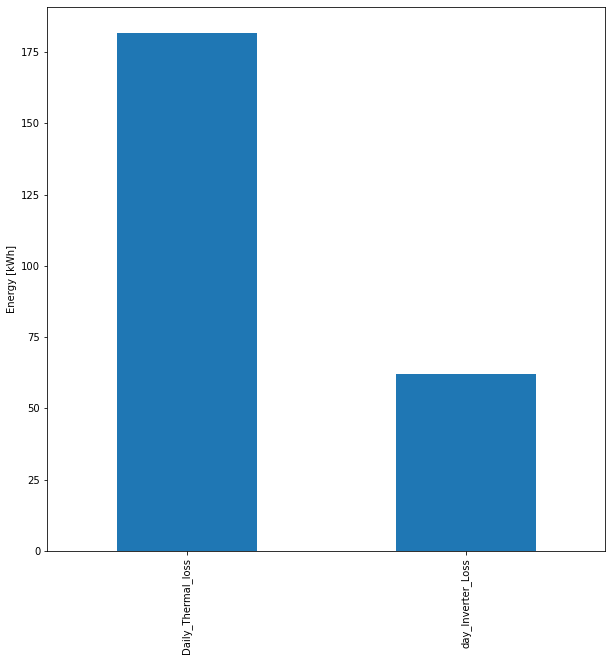

In [31]:
df1 = pd.DataFrame({
    'Daily_Thermal_loss': Thermal_Loss,
    'day_Inverter_Loss': Inverter_Loss
})
df_daily_loss1= (df1/12000).sum()
df_daily_loss1.plot.bar(figsize=(10, 10))
plt.ylabel('Energy [kWh]');

In [32]:
Actual_Power=pd.read_excel('Actual Vs Expected Power (13).xlsx')

In [33]:
Actual_Power['Actual Power(W)']=Actual_Power['Actual Power(kW)']*1000

In [34]:
Actual_Power["DateTime"] = pd.to_datetime(Actual_Power["DateTime"])

In [35]:
Actual_Power= Actual_Power.set_index("DateTime")

In [36]:
Actual_Power.head()

,Actual Power(kW),Actual Power(W)
DateTime,,
2022-03-15 06:10:00,0.0,0.0
2022-03-15 06:15:00,0.0,0.0
2022-03-15 06:20:00,0.2,200.0
2022-03-15 06:25:00,0.5,500.0
2022-03-15 06:30:00,1.2,1200.0


In [37]:
Actual_Power.sum()

Actual Power(kW)       16241.5
Actual Power(W)     16241500.0
dtype: float64

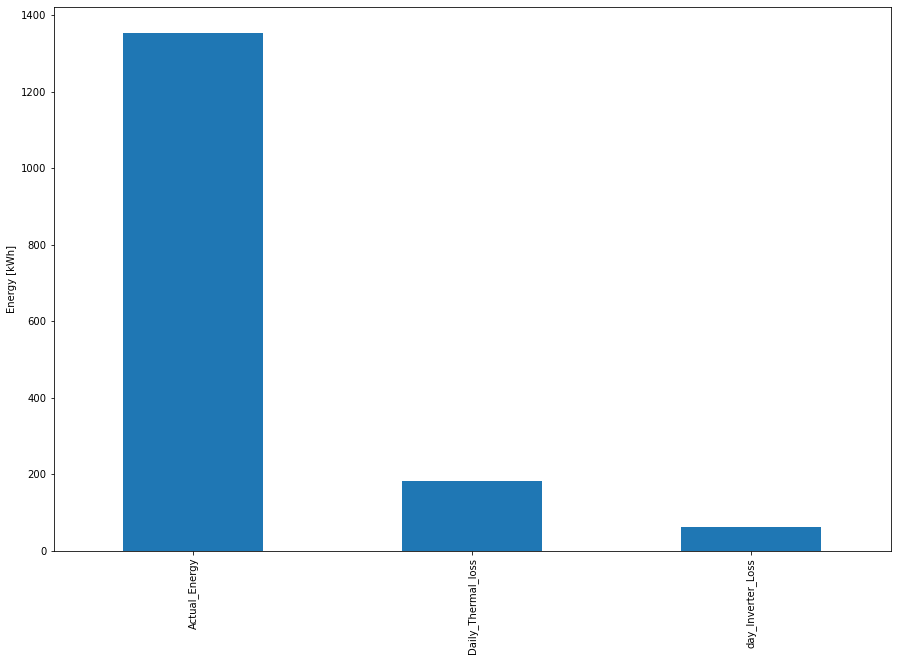

In [38]:
df2 = pd.DataFrame({
    'Actual_Energy': Actual_Power['Actual Power(W)'],
    'Daily_Thermal_loss': Thermal_Loss,
    'day_Inverter_Loss': Inverter_Loss
})
df_daily_loss2= (df2/12000).sum()
df_daily_loss2.plot.bar(figsize=(15, 10))
plt.ylabel('Energy [kWh]');

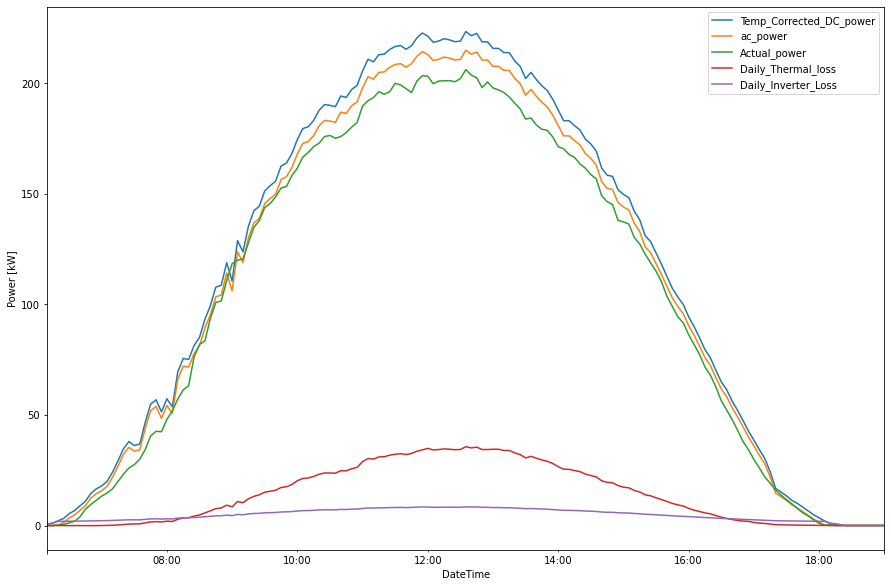

In [39]:
df3 = pd.DataFrame({
    'Temp_Corrected_DC_power': Temp_Corrected_power,
    'ac_power': ac,
    'Actual_power': Actual_Power['Actual Power(W)'],
    'Daily_Thermal_loss': Thermal_Loss,
    'Daily_Inverter_Loss': Inverter_Loss
    
})
df_daily_loss3= (df3/1000)
df_daily_loss3.plot.line(figsize=(15, 10))
plt.ylabel('Power [kW]');

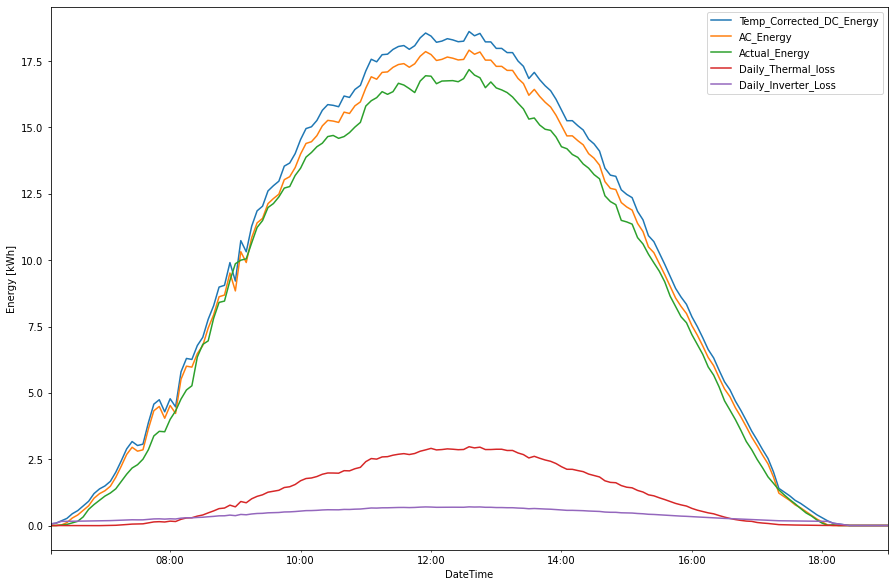

In [40]:
df4 = pd.DataFrame({
    'Temp_Corrected_DC_Energy': Temp_Corrected_power,
    'AC_Energy': ac,
    'Actual_Energy': Actual_Power['Actual Power(W)'],
    'Daily_Thermal_loss': Thermal_Loss,
    'Daily_Inverter_Loss': Inverter_Loss
    
})
df_daily_loss4= (df4/12000)
df_daily_loss4.plot.line(figsize=(15, 10))
plt.ylabel('Energy [kWh]');

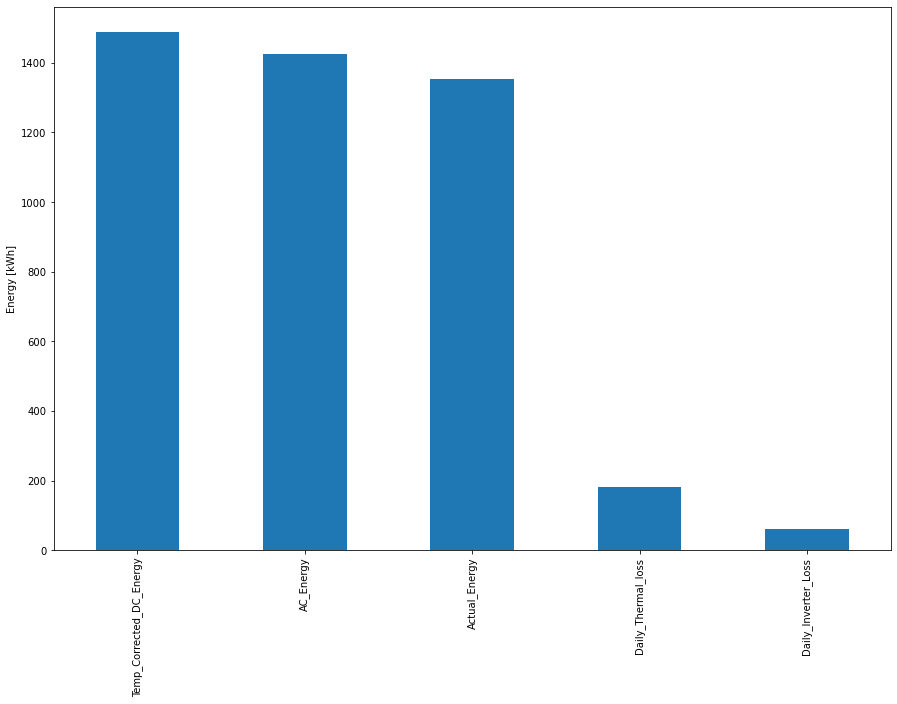

In [41]:
df5 = pd.DataFrame({
    'Temp_Corrected_DC_Energy': Temp_Corrected_power,
    'AC_Energy': ac,
    'Actual_Energy': Actual_Power['Actual Power(W)'],
    'Daily_Thermal_loss': Thermal_Loss,
    'Daily_Inverter_Loss': Inverter_Loss
    
})
df_daily_loss5= (df5/12000).sum()
df_daily_loss5.plot.bar(figsize=(15, 10))
plt.ylabel('Energy [kWh]');

In [42]:
df_daily_loss5

Temp_Corrected_DC_Energy    1486.515906
AC_Energy                   1424.604207
Actual_Energy               1353.458333
Daily_Thermal_loss           181.728594
Daily_Inverter_Loss           61.911699
dtype: float64

In [43]:
df_daily_loss2

Actual_Energy         1353.458333
Daily_Thermal_loss     181.728594
day_Inverter_Loss       61.911699
dtype: float64

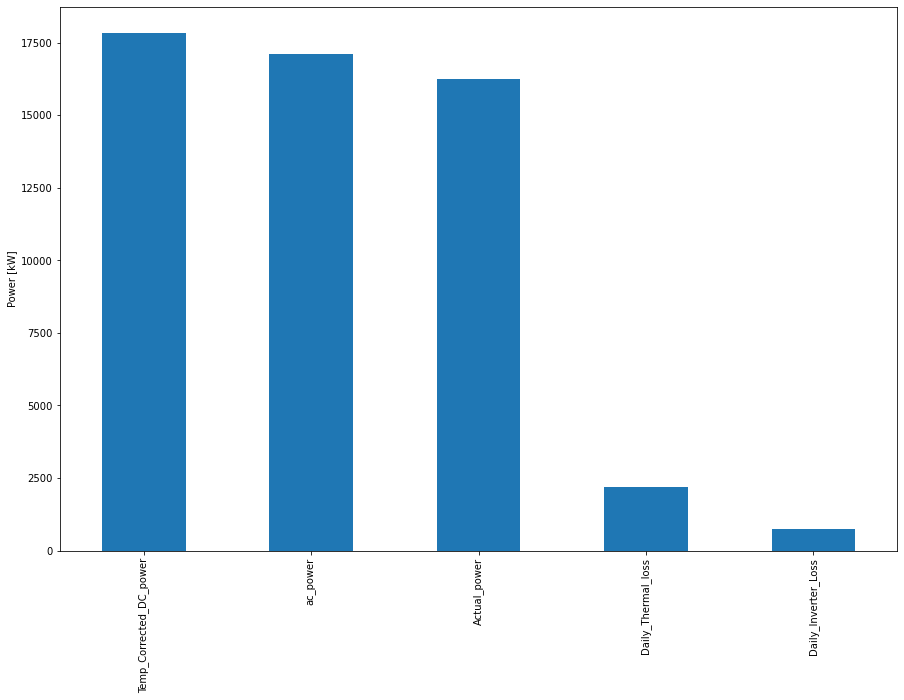

In [47]:
df6 = pd.DataFrame({
    'Temp_Corrected_DC_power': Temp_Corrected_power,
    'ac_power': ac,
    'Actual_power': Actual_Power['Actual Power(W)'],
    'Daily_Thermal_loss': Thermal_Loss,
    'Daily_Inverter_Loss': Inverter_Loss
    
})
df_daily_loss6= (df3/1000).sum()
df_daily_loss6.plot.bar(figsize=(15, 10))
plt.ylabel('Power [kW]');

In [48]:
df_daily_loss6

Temp_Corrected_DC_power    17838.190872
ac_power                   17095.250481
Actual_power               16241.500000
Daily_Thermal_loss          2180.743128
Daily_Inverter_Loss          742.940390
dtype: float64